<a href="https://colab.research.google.com/github/sreeja-g/POS-tagging-codemixed/blob/main/bert_POS_multilingual_roman_dev_trans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import torch

if torch.cuda.is_available():    
   
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
n_gpu = torch.cuda.device_count()

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [3]:
!pip install transformers
!pip install seqeval

In [4]:
import pandas as pd
import csv
import numpy as np
from tqdm import tqdm, trange

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
file_name = '/content/drive/My Drive/POS_dataset/Tel-Hin-POS.tsv'
rows=[]

f = open(file_name, "r")
f_lines = f.readlines()[1:]
f.close()

line_count = 0
for i in range(len(f_lines)):
    if f_lines[i] == "\n": 
        line_count+=1
    else: 
        append_text = "sent: "+str(line_count)+"\t" 
        rows.append(append_text+f_lines[i][:-1])

In [7]:
data = pd.DataFrame([sub.split("\t") for sub in rows], columns = ["Sentence", "Word", "Lang", "POS"])
data.head(20)

,Sentence,Word,Lang,POS
0,sent: 0,leak,en,G_N
1,sent: 0,ea,univ,G_X
2,sent: 0,kaledu,te,G_N
3,sent: 0,.,univ,G_X
4,sent: 0,Megays,en,G_N
5,sent: 0,publicity,univ,G_N
6,sent: 0,stunt,univ,G_N
7,sent: 0,https://,univ,U
8,sent: 0,twitter.com/vineeth170995/,univ,U
9,sent: 0,status/707560457867911169,en,G_N


In [8]:
!pip install indic-transliteration

In [9]:
from indic_transliteration import xsanscript
from indic_transliteration.xsanscript import transliterate

In [10]:
for i in range(len(data)):
    if data.iloc[i]['Lang'] == 'te':
        print(data.iloc[i]['Word'],transliterate(data.iloc[i]['Word'], xsanscript.ITRANS, xsanscript.TELUGU))
        break

kaledu కలెదు


In [11]:
trans_list = []

for i in range(len(data)):
    if data.iloc[i]['Lang'] == 'te':
        trans_word = transliterate(data.iloc[i]['Word'], xsanscript.ITRANS, xsanscript.TELUGU)
        if trans_word == "[UNK]":
            print(i)
            trans_list.append(data.iloc[i]['Word'])
        else:
            trans_list.append(trans_word)
    else:
        trans_list.append(data.iloc[i]['Word'])

data['Trans'] = trans_list
data.head(20)

,Sentence,Word,Lang,POS,Trans
0,sent: 0,leak,en,G_N,leak
1,sent: 0,ea,univ,G_X,ea
2,sent: 0,kaledu,te,G_N,కలెదు
3,sent: 0,.,univ,G_X,.
4,sent: 0,Megays,en,G_N,Megays
5,sent: 0,publicity,univ,G_N,publicity
6,sent: 0,stunt,univ,G_N,stunt
7,sent: 0,https://,univ,U,https://
8,sent: 0,twitter.com/vineeth170995/,univ,U,twitter.com/vineeth170995/
9,sent: 0,status/707560457867911169,en,G_N,status/707560457867911169


In [12]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Trans"].values.tolist(),
                                                           s["Lang"].values.tolist(),
                                                           s["POS"].values.tolist())]
        self.grouped = self.data.groupby("Sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [13]:
getter = SentenceGetter(data[:int(0.7*len(data))])

In [14]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['leak',
 'ea',
 'కలెదు',
 '.',
 'Megays',
 'publicity',
 'stunt',
 'https://',
 'twitter.com/vineeth170995/',
 'status/707560457867911169']

In [15]:
labels = [[s[2] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['G_N', 'G_X', 'G_N', 'G_X', 'G_N', 'G_N', 'G_N', 'U', 'U', 'G_N']


In [16]:
tag_values = list(set(data["POS"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [17]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'1.6.0+cu101'

In [18]:
MAX_LEN = 75
bs = 32

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

In [20]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        tokenized_sentence.extend(tokenized_word)

        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [21]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [22]:
tokenized_texts_and_labels[0]

(['lea',
  '##k',
  'ea',
  'క',
  '##లె',
  '##దు',
  '.',
  'Mega',
  '##ys',
  'public',
  '##ity',
  'st',
  '##unt',
  'https',
  ':',
  '/',
  '/',
  't',
  '##wit',
  '##ter',
  '.',
  'com',
  '/',
  'vin',
  '##eet',
  '##h',
  '##17',
  '##0',
  '##99',
  '##5',
  '/',
  'status',
  '/',
  '707',
  '##5',
  '##60',
  '##45',
  '##7',
  '##86',
  '##7',
  '##91',
  '##11',
  '##69'],
 ['G_N',
  'G_N',
  'G_X',
  'G_N',
  'G_N',
  'G_N',
  'G_X',
  'G_N',
  'G_N',
  'G_N',
  'G_N',
  'G_N',
  'G_N',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'G_N',
  'G_N',
  'G_N',
  'G_N',
  'G_N',
  'G_N',
  'G_N',
  'G_N',
  'G_N',
  'G_N',
  'G_N',
  'G_N'])

In [23]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [24]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [25]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [26]:
input_ids[0], tags[0]

(array([ 20169,  10174,  22257,   1201,  85260,  41711,    119,  35693,
         12682,  11683,  11949,  28780,  20631,  14120,    131,    120,
           120,    188,  56082,  10877,    119,  10212,    120,  38973,
         23203,  10237,  34264,  10929,  88657,  11166,    120,  14042,
           120,  49880,  11166,  50924,  76977,  11305, 103450,  11305,
         74178,  37115,  85147,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0]),
 array([15, 15,  8, 15, 15, 15,  8, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 15, 15, 19, 19, 19, 19, 19, 19, 19, 19,
        19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
        19, 19

In [27]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [28]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [29]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [30]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [31]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'3.4.0'

In [32]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

In [33]:
model.cuda();

In [34]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [35]:
from transformers import get_linear_schedule_with_warmup

epochs = 10
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [36]:
from seqeval.metrics import f1_score, accuracy_score

In [37]:
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
#     print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()


Epoch:  10%|█         | 1/10 [00:05<00:46,  5.11s/it]

Average train loss: 2.129697181961753
Validation loss: 1.5201241374015808
Validation Accuracy: 0.5305232558139535



Epoch:  20%|██        | 2/10 [00:10<00:40,  5.11s/it]

Average train loss: 1.459821105003357
Validation loss: 1.181495189666748
Validation Accuracy: 0.6002906976744186



Epoch:  30%|███       | 3/10 [00:15<00:35,  5.13s/it]

Average train loss: 1.2522310452027754
Validation loss: 1.1329233646392822
Validation Accuracy: 0.6206395348837209



Epoch:  40%|████      | 4/10 [00:20<00:30,  5.16s/it]

Average train loss: 1.120116033337333
Validation loss: 1.0370383560657501
Validation Accuracy: 0.6526162790697675



Epoch:  50%|█████     | 5/10 [00:25<00:25,  5.19s/it]

Average train loss: 1.0216629830273716
Validation loss: 0.9595563113689423
Validation Accuracy: 0.6736918604651163

Average train loss: 0.9424615393985402
Validation loss: 0.991932600736618
Validation Accuracy: 0.6765988372093024



Epoch:  60%|██████    | 6/10 [00:31<00:20,  5.24s/it]

Average train loss: 0.8606607263738458


Epoch:  70%|███████   | 7/10 [00:36<00:15,  5.30s/it]

Validation loss: 0.9959198236465454
Validation Accuracy: 0.6656976744186046

Average train loss: 0.81745845079422


Epoch:  80%|████████  | 8/10 [00:42<00:10,  5.36s/it]

Validation loss: 0.9902970790863037
Validation Accuracy: 0.6620639534883721

Average train loss: 0.753350084478205


Epoch:  90%|█████████ | 9/10 [00:47<00:05,  5.42s/it]

Validation loss: 0.9892494678497314
Validation Accuracy: 0.6678779069767442

Average train loss: 0.73505253683437


Epoch: 100%|██████████| 10/10 [00:53<00:00,  5.34s/it]

Validation loss: 1.005156695842743
Validation Accuracy: 0.6635174418604651



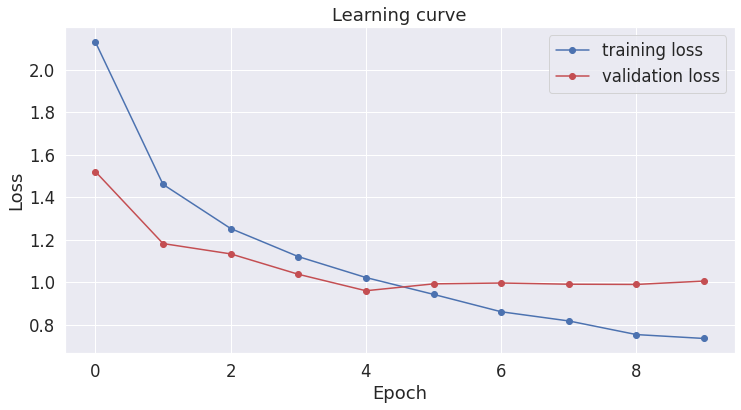

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [39]:
# test_sentence = """
# Mahashivratri bahut achchi festival hai. Aur meri naam Sreeja hai. I love Bangalore jaana. woh khiladi great criketer Virender Singh.
# """
test_sentences = data[int(0.7*len(data)):].groupby('Sentence')['Trans'].apply(lambda x: ' '.join(x)).values

In [40]:
tokenized_sentences = [tokenizer.encode(test_sentence) for test_sentence in test_sentences]
input_ids_all = [torch.tensor([tokenized_sentence]).cuda() for tokenized_sentence in tokenized_sentences]

In [41]:
all_tokens = []
all_labels_pred = []

for input_ids in input_ids_all:
    with torch.no_grad():
        output = model(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

    tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
    new_tokens, new_labels = [], []
    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(tag_values[label_idx])
            new_tokens.append(token)
            
    for token, label in zip(new_tokens, new_labels):
        print("{}\t\t{}".format(label, token))
    
    all_tokens.append(new_tokens)
    all_labels_pred.append(new_labels)

@		[CLS]
@		thappinchi
G_N		reply
G_N		ఇవ్వర
G_X		:
G_N		p
G_X		ఎప్పుదు
G_N		release
G_V		చెస్థరొ
G_N		date
G_V		అయిన
G_V		చెప్పన్ది
@		@
@		DirectorGovi
G_N		గరిని
G_N		adgi
G_X		[SEP]
G_X		[CLS]
@		@
@		supersampangi
G_N		Hater
G_N		అని
G_N		direct
G_V		గ
G_V		చెప్థె
G_V		పర్వలెదు
G_X		bro
G_X		.
G_X		.
G_X		.
G_J		Indirect
G_N		గ
G_V		పొదుస్థు
G_V		ఉన్తదు
G_N		followers
G_X		కొసమ్
G_X		.
G_X		.
G_X		అధె
G_X		కాలుద్ది
G_X		నాకు
G_X		.
G_X		.
G_X		[SEP]
G_X		[CLS]
@		@
@		PawanKalyan
G_X		గరు
G_X		ఇధెమైన
G_N		padhathe
G_X		న
G_X		?
G_X		?
G_X		ఆసలు
G_X		.
G_X		.
G_X		.
U		https
U		:
U		/
U		/
U		twitter
U		.
U		com
U		/
U		TeluguFilmBuzz
U		/
G_N		status
G_N		/
G_N		707823349867671553
G_X		[SEP]
@		[CLS]
@		@
@		meerasayz
G_X		నాకు
G_X		థన
G_N		pics
G_V		చుస్థె
G_X		ah
G_V		రొజన్థ
G_X		ఇదె
G_N		song
G_N		hum
G_V		చెస్థునె
G_X		వున్త
G_X		[SEP]
G_N		[CLS]
G_V		What
G_J		a
G_N		catch
G_N		e
G_V		associate
G_N		teams
G_N		fielding
G_N		అసలు
G_N		మముల్
G_V		గ
G_V		లెదు
G_X		[SEP]
G_X		[CL

In [42]:
getter_test = SentenceGetter(data[int(0.7*len(data)):])

In [43]:
sentences_test = [[word[0] for word in sentence] for sentence in getter_test.sentences]
labels_test = [[s[2] for s in sentence] for sentence in getter_test.sentences]

In [44]:
tokenized_texts_and_labels_test = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences_test, labels_test)
]

In [45]:
tokenized_texts_and_labels_test[0]

(['tha',
  '##ppi',
  '##nchi',
  'rep',
  '##ly',
  'ఇ',
  '##వ్',
  '##వ',
  '##ర',
  ':',
  'p',
  'ఎ',
  '##ప్',
  '##పు',
  '##దు',
  'release',
  'చ',
  '##ెస్',
  '##థ',
  '##ర',
  '##ొ',
  'date',
  'అయిన',
  'చ',
  '##ె',
  '##ప్',
  '##ప',
  '##న్',
  '##ది',
  '@',
  'Director',
  '##G',
  '##ovi',
  'గ',
  '##రి',
  '##ని',
  'ad',
  '##gi'],
 ['G_N',
  'G_N',
  'G_N',
  'G_V',
  'G_V',
  'G_N',
  'G_N',
  'G_N',
  'G_N',
  'E',
  'E',
  'G_J',
  'G_J',
  'G_J',
  'G_J',
  'G_N',
  'G_N',
  'G_N',
  'G_N',
  'G_N',
  'G_N',
  'G_N',
  'G_N',
  'G_X',
  'G_X',
  'G_X',
  'G_X',
  'G_X',
  'G_X',
  '@',
  '@',
  '@',
  '@',
  'G_PRT',
  'G_PRT',
  'G_PRT',
  'G_PRT',
  'G_PRT'])

In [46]:
new_sentence_list = []
new_label_list = []
for each_tokenized_texts_and_labels_test in tokenized_texts_and_labels_test:
    each_sentence_list = each_tokenized_texts_and_labels_test[0]
    each_label_list = each_tokenized_texts_and_labels_test[1]
    each_new_sentence_list = []
    each_new_label_list = []
    i=0
    while i <= len(each_sentence_list)-1:
        new_word = each_sentence_list[i]
        if i+1 < len(each_sentence_list):
            if each_sentence_list[i+1][:2] == '##' and len(each_sentence_list[i+1]) > 2:
                while each_sentence_list[i+1][:2] == '##' and len(each_sentence_list[i+1]) > 2:
                    i+=1
                    new_word += each_sentence_list[i][2:]

                    if i+1 >= len(each_sentence_list):
                        break
                    if each_sentence_list[i+1][:2] != '##' or len(each_sentence_list[i+1]) < 2:
                        break
            
        each_new_sentence_list.append(new_word)
        each_new_label_list.append(each_label_list[i])
        i+=1
    new_sentence_list.append(each_new_sentence_list)
    new_label_list.append(each_new_label_list)

    

In [47]:
for i in range(len(all_tokens)):
    all_tokens[i] = all_tokens[i][1:-1]
    all_labels_pred[i] = all_labels_pred[i][1:-1]

In [48]:
import more_itertools

true_df = pd.DataFrame({
        'Word': more_itertools.flatten(new_sentence_list),
     'Ne': more_itertools.flatten(new_label_list)
    })

pred_df = pd.DataFrame({
        'Word': more_itertools.flatten(all_tokens),
     'Ne': more_itertools.flatten(all_labels_pred)
    })

In [49]:
from IPython.display import display, HTML

In [50]:
display(HTML(pd.concat([pred_df.reset_index(drop=1).add_suffix('_1'),
            true_df.reset_index(drop=1).add_suffix('_2')], axis=1).fillna('').to_html(index = False, justify='left')))

Word_1,Ne_1,Word_2,Ne_2
thappinchi,@,thappinchi,G_N
reply,G_N,reply,G_V
ఇవ్వర,G_N,ఇవ్వర,G_N
:,G_X,:,E
p,G_N,p,E
ఎప్పుదు,G_X,ఎప్పుదు,G_J
release,G_N,release,G_N
చెస్థరొ,G_V,చెస్థరొ,G_N
date,G_N,date,G_N
అయిన,G_V,అయిన,G_N


In [51]:
from sklearn.metrics import classification_report

In [52]:
print(classification_report(list(more_itertools.flatten(new_label_list)), list(more_itertools.flatten(all_labels_pred))))

              precision    recall  f1-score   support

           #       0.80      0.98      0.88        46
           $       1.00      0.19      0.32        48
           @       0.98      1.00      0.99       292
          CC       0.00      0.00      0.00        20
          DT       0.00      0.00      0.00        35
           E       1.00      0.11      0.20        18
          G_       0.00      0.00      0.00         1
         G_J       0.49      0.33      0.40        97
         G_N       0.70      0.72      0.71       981
       G_PRP       0.17      0.01      0.03        73
       G_PRT       0.56      0.23      0.33        64
         G_R       0.00      0.00      0.00        48
         G_V       0.33      0.46      0.39       190
         G_X       0.57      0.81      0.67       609
         PSP       0.40      0.07      0.12        83
           U       0.93      0.97      0.95       180
        null       0.00      0.00      0.00         4
           ~       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
